# mout my drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# install Requirements

In [2]:
!pip install git+https://github.com/dicarlolab/CORnet.git

  Cloning https://github.com/dicarlolab/CORnet.git to /tmp/pip-req-build-nk7jio3z
  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet.git /tmp/pip-req-build-nk7jio3z
  Resolved https://github.com/dicarlolab/CORnet.git to commit d0cc17d4b34ad44dedb01683b70eafd15515adad
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for CORnet: filename=CORnet-0.1.0-py3-none-any.whl size=23228 sha256=9ba64ab6fdf94a51429eb6417e7c7ce3300e9b13feb3c5008181c371e67e791e
  Stored in directory: /tmp/pip-ephem-wheel-cache-c3lttqvv/wheels/7d/71/5d/ff4f86828632f02f6bf3f16b6e5f5e1b166c4419547dd26517
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=94140ad079389fb666b4a894de5c30900ef86a0ae90f4af408f7eb9c2cd64ace
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89

# Libraries

In [3]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# 1) Install cornet from GitHub if not installed:
#    pip install git+https://github.com/dicarlolab/CORnet.git
from cornet import cornet_rt
from torch.utils.data import DataLoader
from scipy.stats import ttest_rel


In [4]:
import os

data_dir = "/content/drive/MyDrive/data"
for root, dirs, files in os.walk(data_dir):
    print("Directory:", root)
    for file in files:
        print("  File:", file)


Directory: /content/drive/MyDrive/data
Directory: /content/drive/MyDrive/data/.ipynb_checkpoints
Directory: /content/drive/MyDrive/data/class0_1
  File: img24.jpeg
  File: img23.jpeg
  File: img33.jpeg
  File: img27.jpeg
  File: img16.jpeg
  File: img30.jpeg
  File: img6.jpeg
  File: img18.jpeg
  File: img36.jpeg
  File: img28.jpeg
  File: img8.jpeg
  File: img26.jpeg
  File: img9.jpeg
  File: img32.jpeg
  File: img2.jpeg
  File: img25.jpeg
  File: img14.jpeg
  File: img10.jpeg
  File: img13.jpeg
  File: img15.jpeg
  File: img35.jpeg
  File: img1.jpeg
  File: img17.jpeg
  File: img29.jpeg
  File: img4.jpeg
  File: img3.jpeg
  File: img5.jpeg
  File: img11.jpeg
  File: img34.jpeg
  File: img31.jpeg
  File: img7.jpeg
  File: img12.jpeg
  File: img22.jpeg
  File: img19.jpeg
  File: img20.jpeg
  File: img21.jpeg
Directory: /content/drive/MyDrive/data/class0_2
  File: img14.jpeg
  File: img16.jpeg
  File: img7.jpeg
  File: img3.jpeg
  File: img32.jpeg
  File: img19.jpeg
  File: img31.jpeg
 

In [5]:
import os
from torch.utils.data import Dataset
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, root_dirs, transform=None):
        """
        Args:
            root_dirs (list of str): List of folder paths in the desired order.
            transform (callable, optional): Transform to be applied on an image.
        """
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for idx, folder in enumerate(root_dirs):
            if os.path.basename(folder).startswith('.'):
                continue  # Skip hidden folders like .ipynb_checkpoints
            folder_paths = sorted(
                [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            )
            self.image_paths.extend(folder_paths)
            self.labels.extend([idx] * len(folder_paths))  # Label by order in root_dirs

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [6]:
data_dirs = [
    "/content/drive/MyDrive/data/class0_1",
    "/content/drive/MyDrive/data/class1_1",
    "/content/drive/MyDrive/data/class0_2",
    "/content/drive/MyDrive/data/class1_2",
]

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = CustomImageDataset(root_dirs=data_dirs, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

print("Number of images in dataset:", len(dataset))


Number of images in dataset: 144


In [14]:
#!/usr/bin/env python3

import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

################################################################################
# 1) Installation & Imports
################################################################################
# If you haven't installed CORnet:
#   pip install git+https://github.com/dicarlolab/CORnet.git
from cornet import cornet_rt

################################################################################
# 2) Device Setup
################################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

################################################################################
# 3) Load the Pretrained CORnet-S (No Fine-Tuning)
################################################################################
# This model is pretrained on ImageNet (1000-class)
model = cornet_rt(pretrained=True).to(device)
model.eval()  # no fine-tuning

# CORnet-S often returns a dictionary with keys like {'out': logits, 'r4': ...}
# The final part of the model is:
#   (decoder): Sequential(
#       (avgpool): AdaptiveAvgPool2d(output_size=1)
#       (flatten): Flatten()
#       (linear): Linear(in_features=512, out_features=1000, bias=True)
#       (output): Identity()
#   )
# We'll place a hook on "flatten" to capture the 512D features.

extracted = {}
def hook_fn(module, input_, output_):
    # output_ shape: [batch_size, 512]
    extracted['penultimate'] = output_

# Register the forward hook on the flatten layer
# If not wrapped in DataParallel, you can directly access model.decoder.flatten
flatten_layer = model.module.decoder.linear
hook = flatten_layer.register_forward_hook(hook_fn)

################################################################################
# 4) Build a Dataset & Dataloader
################################################################################
# Example: using ImageFolder if you have:
# data/
#   class0/
#       img0.jpg, img1.jpg, ...
#   class1/
#       img2.jpg, ...
# or any such structure.
# If your images are all in a single folder, you can adapt it or create a custom dataset.


################################################################################
# 5) Extract 512D Penultimate Features for Each Image
################################################################################
all_features = []
all_labels = []

with torch.no_grad():
    for img, lab in loader:
        img = img.to(device)

        # Forward pass => triggers the hook, storing output in extracted['penultimate']
        _ = model(img)

        # Retrieve the 512D features from the hook
        feats_512 = extracted['penultimate']  # shape: [1, 512]
        feats_512 = feats_512.squeeze(0).cpu().numpy()  # shape: (512,)

        all_features.append(feats_512)
        all_labels.append(lab.item())  # if you care about the label

all_features = np.array(all_features)  # shape: (N, 512)
all_labels = np.array(all_labels)
print("Extracted feature matrix shape:", all_features.shape)
print("Labels shape:", all_labels.shape)

# Optional check: if you have 144 images, shape should be (144, 512).

################################################################################
# 6) Build the RDM (1 - correlation)
################################################################################
# We'll do a correlation-like measure: center, normalize, dot => correlation

X = all_features  # (N, 512)
X_centered = X - X.mean(axis=1, keepdims=True)
norms = np.linalg.norm(X_centered, axis=1, keepdims=True)
X_norm = X_centered / (norms + 1e-8)

# Dot product => approximate correlation
cor_mat = np.dot(X_norm, X_norm.T)  # shape: (N, N)

RDM = 1 - cor_mat  # shape: (N, N)

print("RDM shape:", RDM.shape)  # Should be (144,144) if you have 144 images

################################################################################
# 7) Visualize the RDM
################################################################################
plt.figure(figsize=(6, 5))
plt.imshow(RDM, cmap='viridis')
plt.colorbar(label='1 - correlation')
plt.title('RDM (512D Penultimate Features, Pretrained CORnet-S)')
plt.show()

################################################################################
# 8) Save the RDM as .mat
################################################################################
sio.savemat('RDM_pretrained.mat', {'RDM': RDM})
print("Saved RDM to RDM_pretrained.mat")


Using device: cpu


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
X = all_features
X_centered = X - X.mean(axis=1, keepdims=True)
norms = np.linalg.norm(X_centered, axis=1, keepdims=True)
X_norm = X_centered / (norms + 1e-12)
cor_mat = np.dot(X_norm, X_norm.T)  # (N, N)
RDM = 1 - cor_mat

print("RDM shape:", RDM.shape)  # should be (N, N)

import matplotlib.pyplot as plt
plt.imshow(RDM, cmap='viridis')
plt.colorbar(label='1 - correlation')
plt.title('RDM from 512D Features (Pre-Linear)')
plt.show()


In [ ]:
import numpy as np
import scipy.io as sio

# Suppose RDM is a NumPy array of shape (N, N)
RDM = np.random.rand(144, 144)  # for illustration

# Use savemat to save as .mat
sio.savemat('RDM_matrix.mat', {'RDM': RDM})

print("Saved RDM to RDM_matrix.mat")


# AlexNet

In [ ]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

################################################################################
# 1) Device Setup
################################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

################################################################################
# 2) Load the Pretrained AlexNet
################################################################################
# Load pretrained AlexNet model
model = torchvision.models.alexnet(pretrained=True).to(device)
model.eval()  # Set to evaluation mode

# AlexNet's penultimate layer before the final classifier is:
#   (classifier): Sequential(
#       (0): Dropout(p=0.5, inplace=False)
#       (1): Linear(in_features=9216, out_features=4096, bias=True)
#       (2): ReLU(inplace=True)
#       (3): Dropout(p=0.5, inplace=False)
#       (4): Linear(in_features=4096, out_features=4096, bias=True)
#       (5): ReLU(inplace=True)
#       (6): Linear(in_features=4096, out_features=1000, bias=True)
#   )
# We'll place a hook on the second-to-last linear layer (index 4).

extracted = {}
def hook_fn(module, input_, output_):
    # output_ shape: [batch_size, 4096]
    extracted['penultimate'] = output_

# Register the forward hook on the second-to-last linear layer
penultimate_layer = model.classifier[6]
hook = penultimate_layer.register_forward_hook(hook_fn)

################################################################################
# 3) Dataset Setup
################################################################################
data_dirs = [
    "/content/drive/MyDrive/data/class0_1",
    "/content/drive/MyDrive/data/class1_1",
    "/content/drive/MyDrive/data/class0_2",
    "/content/drive/MyDrive/data/class1_2",
]

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dirs, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        for idx, folder in enumerate(root_dirs):
            if os.path.basename(folder).startswith('.'):
                continue
            folder_paths = sorted(
                [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
            )
            self.image_paths.extend(folder_paths)
            self.labels.extend([idx] * len(folder_paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

dataset = CustomImageDataset(root_dirs=data_dirs, transform=transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

print("Number of images in dataset:", len(dataset))

################################################################################
# 4) Extract 4096D Features for Each Image
################################################################################
all_features = []
all_labels = []

with torch.no_grad():
    for img, lab in loader:
        img = img.to(device)

        # Forward pass => triggers the hook, storing output in extracted['penultimate']
        _ = model(img)

        # Retrieve the 4096D features from the hook
        feats_4096 = extracted['penultimate']  # shape: [1, 4096]
        feats_4096 = feats_4096.squeeze(0).cpu().numpy()  # shape: (4096,)

        all_features.append(feats_4096)
        all_labels.append(lab.item())  # if you care about the label

all_features = np.array(all_features)  # shape: (N, 4096)
all_labels = np.array(all_labels)
print("Extracted feature matrix shape:", all_features.shape)
print("Labels shape:", all_labels.shape)

################################################################################
# 5) Build the RDM (1 - correlation)
################################################################################
X = all_features  # (N, 4096)
X_centered = X - X.mean(axis=1, keepdims=True)
norms = np.linalg.norm(X_centered, axis=1, keepdims=True)
X_norm = X_centered / (norms + 1e-8)

# Dot product => approximate correlation
cor_mat = np.dot(X_norm, X_norm.T)  # shape: (N, N)

RDM = 1 - cor_mat  # shape: (N, N)

print("RDM shape:", RDM.shape)  # Should be (144,144) if you have 144 images

################################################################################
# 6) Visualize the RDM
################################################################################
plt.figure(figsize=(6, 5))
plt.imshow(RDM, cmap='viridis')
plt.colorbar(label='1 - correlation')
plt.title('RDM (4096D Features, Pretrained AlexNet)')
plt.show()

################################################################################
# 7) Save the RDM as .mat
################################################################################
sio.savemat('RDM_pretrained_alexnet.mat', {'RDM': RDM})
print("Saved RDM to RDM_pretrained_alexnet.mat")


# Comparison PFC VAR

In [7]:
import h5py

def load_files(path , dataName):
    with h5py.File(path, 'r') as data:
        data_vec = data[dataName]
        # Get the shape of the data
        shape = data_vec.shape
        data_vec = np.array(data_vec)
        print(f"The shape is: {shape}")
        return data_vec

In [8]:
r_rnn_PFC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_rnn_PFC.mat' , 'r_rnn')
pVals_r_rnn_PFC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_rnn_PFC.mat' , 'p_rnn')

r_alexnet_PFC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_alexnet_PFC.mat' , 'r_alexnet')
pVals_r_alexnet_PFC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_alexnet_PFC.mat' , 'p_alexnet')


The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)


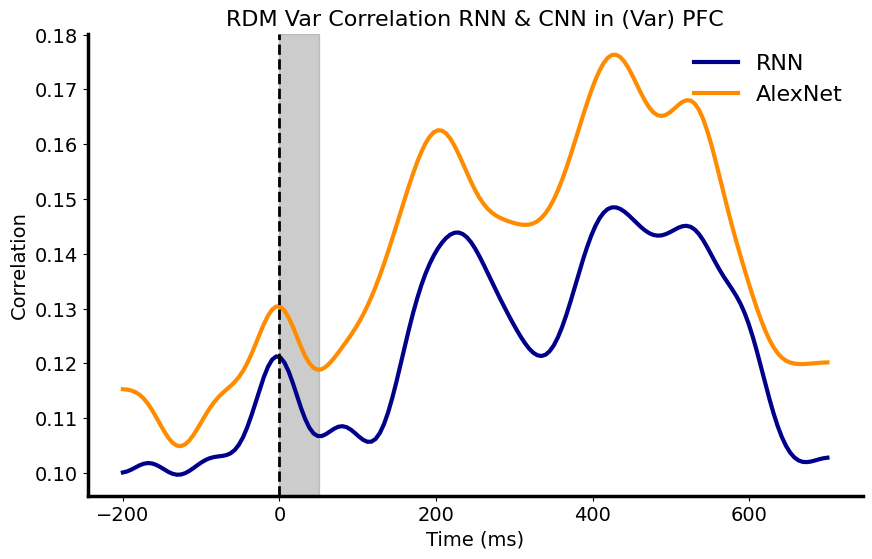

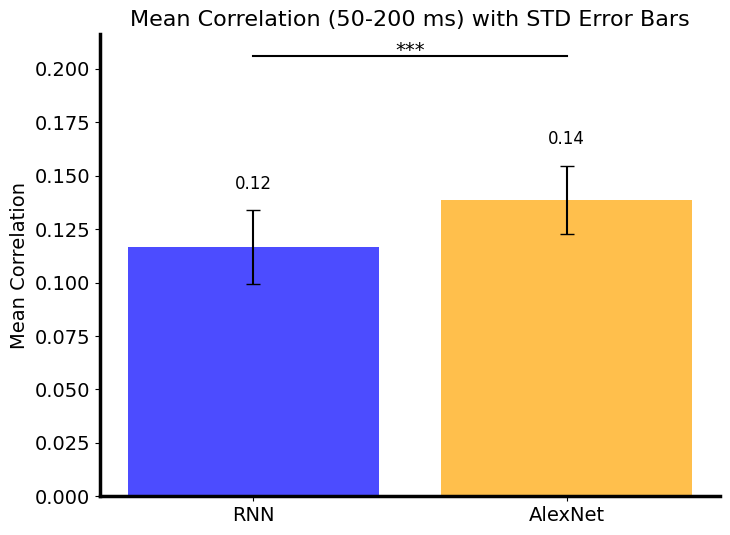

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Assuming r_rnn_PFC, r_alexnet_PFC, and time are defined
time = np.linspace(-200, 700, 171)
region = 'PFC'

# Convert 2D arrays to 1D
r_rnn_PFC = np.squeeze(r_rnn_PFC)  # Shape: (171,)
r_alexnet_PFC = np.squeeze(r_alexnet_PFC)  # Shape: (171,)

# Apply Gaussian smoothing
sigma = 5  # Adjust as needed for the desired level of smoothing
r_rnn_smooth = gaussian_filter1d(r_rnn_PFC, sigma=sigma)
r_alexnet_smooth = gaussian_filter1d(r_alexnet_PFC, sigma=sigma)

# Plot original vs smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time, r_rnn_smooth, linewidth=3, label='RNN', color='darkblue')
plt.plot(time, r_alexnet_smooth, linewidth=3, label='AlexNet', color='darkorange')

# Customize the plot
plt.grid(False)
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title(f'RDM Var Correlation RNN & CNN in (Var) {region}', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Highlight the stimulus display from 0 to 50 ms with a gray region
plt.axvspan(0, 50, color='gray', alpha=0.4)

# Show the onset of stimulus with a dashed line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
# Customize the legend
plt.legend(fontsize=16, loc='upper right', frameon=False)  # Top-right position without box


# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.show()

# Step 1: Define the time window
time_window_start = 50  # Start of the window (ms)
time_window_end = 200   # End of the window (ms)

# Find indices corresponding to the time window
window_indices = np.where((time >= time_window_start) & (time <= time_window_end))[0]

if len(window_indices) == 0:
    raise ValueError('No time points found in the specified time window.')

# Extract the correlation coefficients within the time window
corr_rnn_window = r_rnn_PFC[window_indices]
corr_alexnet_window = r_alexnet_PFC[window_indices]

# Step 2: Calculate mean and standard deviation
mean_rnn = np.nanmean(corr_rnn_window)
std_rnn = np.nanstd(corr_rnn_window)
mean_alexnet = np.nanmean(corr_alexnet_window)
std_alexnet = np.nanstd(corr_alexnet_window)

# Step 3: Perform paired t-test
t_stat, p_value = ttest_rel(corr_rnn_window, corr_alexnet_window, nan_policy='omit')

# Step 4: Create bar plot with error bars
means = [mean_rnn, mean_alexnet]
stds = [std_rnn, std_alexnet]
labels = ['RNN', 'AlexNet']

ax2 = plt.figure(figsize=(8, 6))
bar_handle = plt.bar(range(len(means)), means, yerr=stds, capsize=5, color=['blue', 'orange'], alpha=0.7)
plt.xticks(range(len(means)), labels, fontsize=12)
plt.ylabel('Mean Correlation', fontsize=14)
plt.title('Mean Correlation (50-200 ms) with STD Error Bars', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Display exact values on top of the bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.01, f'{mean:.2f}', ha='center', fontsize=12)

# Annotate the plot with the p-value
annotation_x = [0, 1]
annotation_y = max(means) + max(stds) + 0.05
plt.plot(annotation_x, [annotation_y, annotation_y], 'k-', linewidth=1.5)

if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'n.s.'

plt.text(0.5, annotation_y , significance, ha='center', fontsize=14)

# Optional: Add the exact p-value
# plt.text(0.5, annotation_y + 0.04, f'p = {p_value:.3f}', ha='center', fontsize=12)



# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.show()




# Comparison PFC Fr

In [10]:
r_rnn_PFC_firing = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_rnn_firing_PFC.mat' , 'r_rnn')
pVals_r_rnn_PFC_firing = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_rnn_firing_PFC.mat' , 'p_rnn')

r_alexnet_PFC_firing = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_alexnet_firing_PFC.mat' , 'r_alexnet')
pVals_r_alexnet_PFC_firing = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_alexnet_firing_PFC.mat' , 'p_alexnet')


The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)


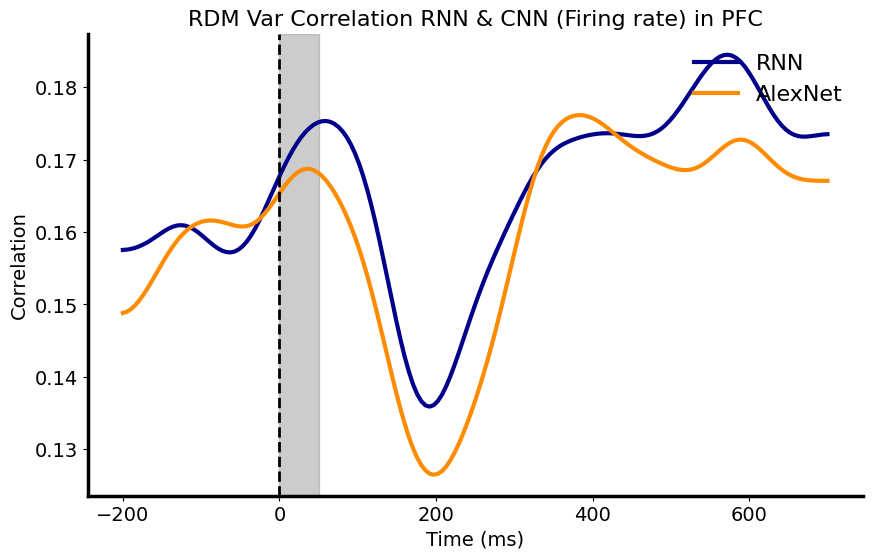

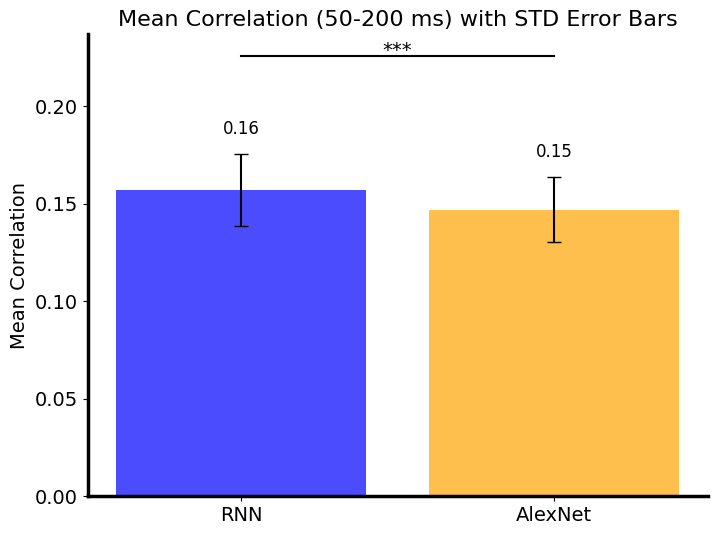

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Assuming r_rnn_PFC, r_alexnet_PFC, and time are defined
time = np.linspace(-200, 700, 171)
region = 'PFC'

# Convert 2D arrays to 1D
r_rnn_PFC_firing = np.squeeze(r_rnn_PFC_firing)  # Shape: (171,)
r_alexnet_PFC_firing = np.squeeze(r_alexnet_PFC_firing)  # Shape: (171,)

# Apply Gaussian smoothing
sigma = 5  # Adjust as needed for the desired level of smoothing
r_rnn_smooth_firing = gaussian_filter1d(r_rnn_PFC_firing, sigma=sigma)
r_alexnet_smooth_firing = gaussian_filter1d(r_alexnet_PFC_firing, sigma=sigma)

# Plot original vs smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time, r_rnn_smooth_firing, linewidth=3, label='RNN', color='darkblue')
plt.plot(time, r_alexnet_smooth_firing, linewidth=3, label='AlexNet', color='darkorange')

# Customize the plot
plt.grid(False)
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title(f'RDM Var Correlation RNN & CNN (Firing rate) in {region}', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Highlight the stimulus display from 0 to 50 ms with a gray region
plt.axvspan(0, 50, color='gray', alpha=0.4)

# Show the onset of stimulus with a dashed line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
# Customize the legend
plt.legend(fontsize=16, loc='upper right', frameon=False)  # Top-right position without box


# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.show()

# Step 1: Define the time window
time_window_start = 50  # Start of the window (ms)
time_window_end = 200   # End of the window (ms)

# Find indices corresponding to the time window
window_indices = np.where((time >= time_window_start) & (time <= time_window_end))[0]

if len(window_indices) == 0:
    raise ValueError('No time points found in the specified time window.')

# Extract the correlation coefficients within the time window
corr_rnn_window = r_rnn_PFC_firing[window_indices]
corr_alexnet_window = r_alexnet_PFC_firing[window_indices]

# Step 2: Calculate mean and standard deviation
mean_rnn = np.nanmean(corr_rnn_window)
std_rnn = np.nanstd(corr_rnn_window)
mean_alexnet = np.nanmean(corr_alexnet_window)
std_alexnet = np.nanstd(corr_alexnet_window)

# Step 3: Perform paired t-test
t_stat, p_value = ttest_rel(corr_rnn_window, corr_alexnet_window, nan_policy='omit')

# Step 4: Create bar plot with error bars
means = [mean_rnn, mean_alexnet]
stds = [std_rnn, std_alexnet]
labels = ['RNN', 'AlexNet']

ax2 = plt.figure(figsize=(8, 6))
bar_handle = plt.bar(range(len(means)), means, yerr=stds, capsize=5, color=['blue', 'orange'], alpha=0.7)
plt.xticks(range(len(means)), labels, fontsize=12)
plt.ylabel('Mean Correlation', fontsize=14)
plt.title('Mean Correlation (50-200 ms) with STD Error Bars', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Display exact values on top of the bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.01, f'{mean:.2f}', ha='center', fontsize=12)

# Annotate the plot with the p-value
annotation_x = [0, 1]
annotation_y = max(means) + max(stds) + 0.05
plt.plot(annotation_x, [annotation_y, annotation_y], 'k-', linewidth=1.5)

if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'n.s.'

plt.text(0.5, annotation_y , significance, ha='center', fontsize=14)

# Optional: Add the exact p-value
# plt.text(0.5, annotation_y + 0.04, f'p = {p_value:.3f}', ha='center', fontsize=12)



# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.show()




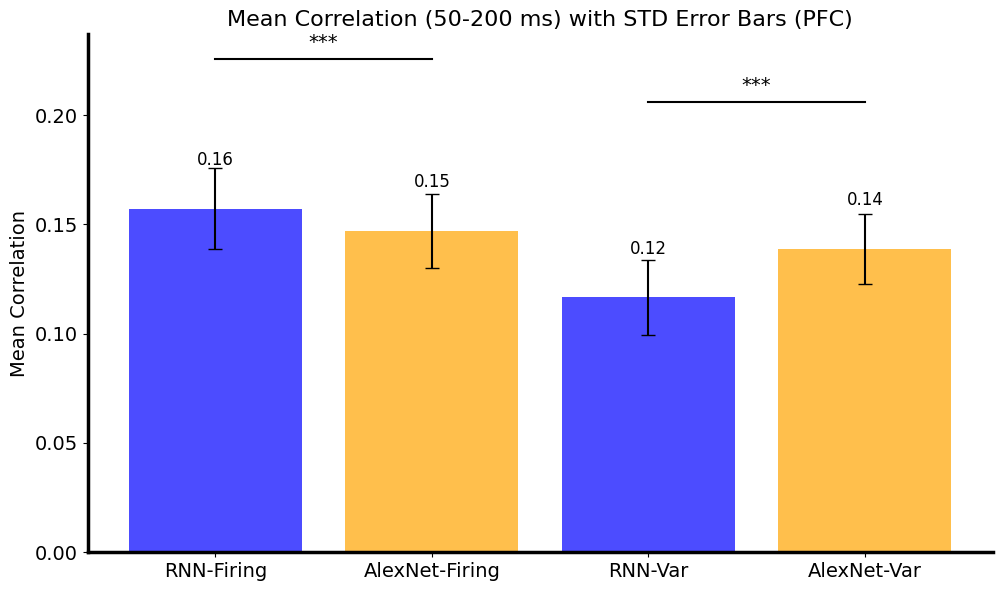

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Assuming time, r_rnn_PFC, r_alexnet_PFC, r_rnn_PFC_firing, r_alexnet_PFC_firing are defined

# Step 1: Define the time window
time_window_start = 50  # Start of the window (ms)
time_window_end = 200   # End of the window (ms)

# Find indices corresponding to the time window
window_indices = np.where((time >= time_window_start) & (time <= time_window_end))[0]

if len(window_indices) == 0:
    raise ValueError('No time points found in the specified time window.')

# Extract data for Firing rate
corr_rnn_firing = r_rnn_PFC_firing[window_indices]
corr_alexnet_firing = r_alexnet_PFC_firing[window_indices]

# Extract data for Variance
corr_rnn_var = r_rnn_PFC[window_indices]
corr_alexnet_var = r_alexnet_PFC[window_indices]

# Step 2: Calculate mean and standard deviation
mean_rnn_firing = np.nanmean(corr_rnn_firing)
std_rnn_firing = np.nanstd(corr_rnn_firing)
mean_alexnet_firing = np.nanmean(corr_alexnet_firing)
std_alexnet_firing = np.nanstd(corr_alexnet_firing)

mean_rnn_var = np.nanmean(corr_rnn_var)
std_rnn_var = np.nanstd(corr_rnn_var)
mean_alexnet_var = np.nanmean(corr_alexnet_var)
std_alexnet_var = np.nanstd(corr_alexnet_var)

# Step 3: Perform paired t-tests
t_stat_firing, p_value_firing = ttest_rel(corr_rnn_firing, corr_alexnet_firing, nan_policy='omit')
t_stat_var, p_value_var = ttest_rel(corr_rnn_var, corr_alexnet_var, nan_policy='omit')

# Step 4: Combine data for plotting
means = [mean_rnn_firing, mean_alexnet_firing, mean_rnn_var, mean_alexnet_var]
stds = [std_rnn_firing, std_alexnet_firing, std_rnn_var, std_alexnet_var]
x_labels = ['RNN-Firing', 'AlexNet-Firing', 'RNN-Var', 'AlexNet-Var']

# Step 5: Create a grouped bar plot
x = np.arange(len(x_labels))  # Bar positions
colors = ['blue', 'orange', 'blue', 'orange']  # Colors for bars

plt.figure(figsize=(10, 6))
bars = plt.bar(x, means, yerr=stds, capsize=5, color=colors, alpha=0.7)



# Add values above bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f'{means[i]:.2f}', ha='center', fontsize=12)

# Customize plot
plt.xticks(x, x_labels, fontsize=12)
plt.ylabel('Mean Correlation', fontsize=14)
plt.title('Mean Correlation (50-200 ms) with STD Error Bars (PFC)', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Annotate p-values
p_values = [p_value_firing, p_value_var]
annotations = [[0, 1], [2, 3]]  # Group bar pairs for significance annotations
for i, (p_value, annotation) in enumerate(zip(p_values, annotations)):
    significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'n.s.'
    annotation_y = max(means[annotation[0]:annotation[1]+2]) + max(stds[annotation[0]:annotation[1]+1]) + 0.05
    plt.plot(annotation, [annotation_y, annotation_y], 'k-', linewidth=1.5)
    plt.text(sum(annotation) / 2, annotation_y + 0.005, significance, ha='center', fontsize=14)

plt.tight_layout()




# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.show()


# Comparison ITC VAR

In [26]:
r_rnn_ITC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_rnn_ITC.mat' , 'r_rnn')
pVals_r_rnn_ITC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_rnn_ITC.mat' , 'p_rnn')

r_alexnet_ITC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_alexnet_ITC.mat' , 'r_alexnet')
pVals_r_alexnet_ITC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_alexnet_ITC.mat' , 'p_alexnet')

The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)


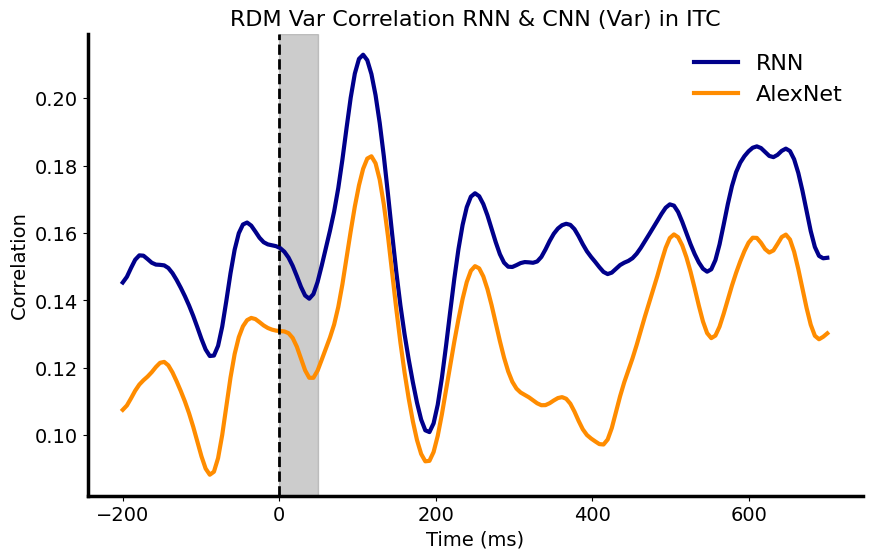

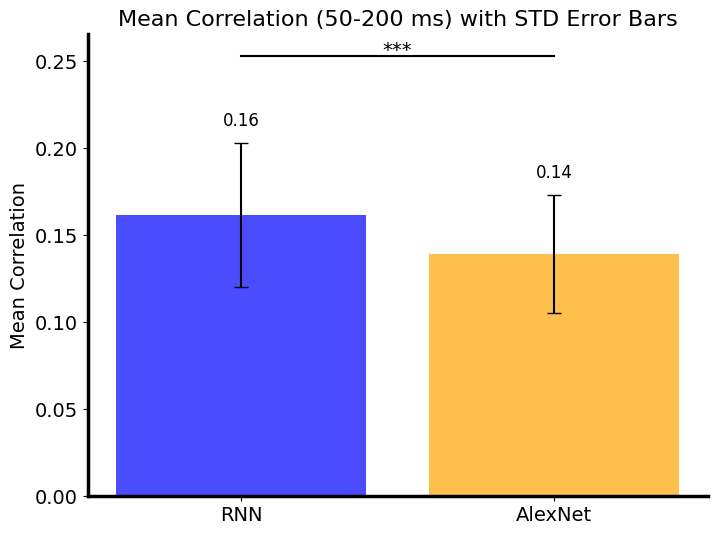

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Assuming r_rnn_PFC, r_alexnet_PFC, and time are defined
time = np.linspace(-200, 700, 171)
region = 'ITC'

# Convert 2D arrays to 1D
r_rnn_ITC = np.squeeze(r_rnn_ITC)  # Shape: (171,)
r_alexnet_ITC = np.squeeze(r_alexnet_ITC)  # Shape: (171,)

# Apply Gaussian smoothing
sigma = 2  # Adjust as needed for the desired level of smoothing
r_rnn_smooth = gaussian_filter1d(r_rnn_ITC, sigma=sigma)
r_alexnet_smooth = gaussian_filter1d(r_alexnet_ITC, sigma=sigma)

# Plot original vs smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time, r_rnn_smooth, linewidth=3, label='RNN', color='darkblue')
plt.plot(time, r_alexnet_smooth, linewidth=3, label='AlexNet', color='darkorange')

# Customize the plot
plt.grid(False)
plt.legend(fontsize=12)
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title(f'RDM Var Correlation RNN & CNN (Var) in {region}', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Highlight the stimulus display from 0 to 50 ms with a gray region
plt.axvspan(0, 50, color='gray', alpha=0.4)

# Show the onset of stimulus with a dashed line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)
# Customize the legend
plt.legend(fontsize=16, loc='upper right', frameon=False)  # Top-right position without box


# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.show()

# Step 1: Define the time window
time_window_start = 50  # Start of the window (ms)
time_window_end = 200   # End of the window (ms)

# Find indices corresponding to the time window
window_indices = np.where((time >= time_window_start) & (time <= time_window_end))[0]

if len(window_indices) == 0:
    raise ValueError('No time points found in the specified time window.')

# Extract the correlation coefficients within the time window
corr_rnn_window = r_rnn_ITC[window_indices]
corr_alexnet_window = r_alexnet_ITC[window_indices]

# Step 2: Calculate mean and standard deviation
mean_rnn = np.nanmean(corr_rnn_window)
std_rnn = np.nanstd(corr_rnn_window)
mean_alexnet = np.nanmean(corr_alexnet_window)
std_alexnet = np.nanstd(corr_alexnet_window)

# Step 3: Perform paired t-test
t_stat, p_value = ttest_rel(corr_rnn_window, corr_alexnet_window, nan_policy='omit')

# Step 4: Create bar plot with error bars
means = [mean_rnn, mean_alexnet]
stds = [std_rnn, std_alexnet]
labels = ['RNN', 'AlexNet']

ax2 = plt.figure(figsize=(8, 6))
bar_handle = plt.bar(range(len(means)), means, yerr=stds, capsize=5, color=['blue', 'orange'], alpha=0.7)
plt.xticks(range(len(means)), labels, fontsize=12)
plt.ylabel('Mean Correlation', fontsize=14)
plt.title('Mean Correlation (50-200 ms) with STD Error Bars', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Display exact values on top of the bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.01, f'{mean:.2f}', ha='center', fontsize=12)

# Annotate the plot with the p-value
annotation_x = [0, 1]
annotation_y = max(means) + max(stds) + 0.05
plt.plot(annotation_x, [annotation_y, annotation_y], 'k-', linewidth=1.5)

if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'n.s.'

plt.text(0.5, annotation_y , significance, ha='center', fontsize=14)

# Optional: Add the exact p-value
# plt.text(0.5, annotation_y + 0.04, f'p = {p_value:.3f}', ha='center', fontsize=12)



# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.show()




# Comparision ITC FR

In [28]:
r_rnn_ITC_firing = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_rnn_firing_ITC.mat' , 'r_rnn')
pVals_r_rnn_ITC_firing = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_rnn_firing_ITC.mat' , 'p_rnn')

r_alexnet_ITC_firing = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_alexnet_firing_ITC.mat' , 'r_alexnet')
pVals_r_alexnet_ITC_firing = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_alexnet_firing_ITC.mat' , 'p_alexnet')

The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)


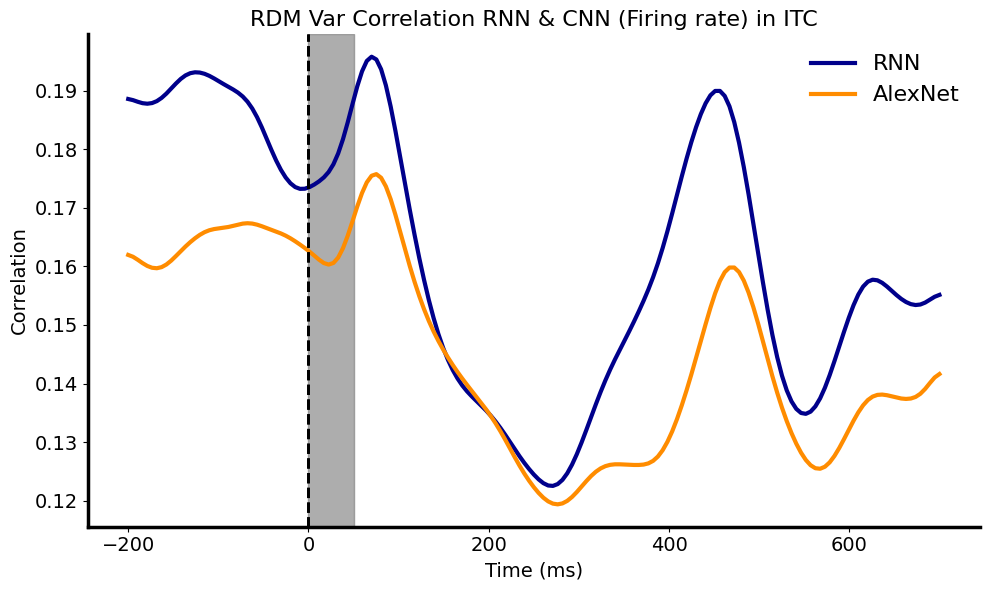

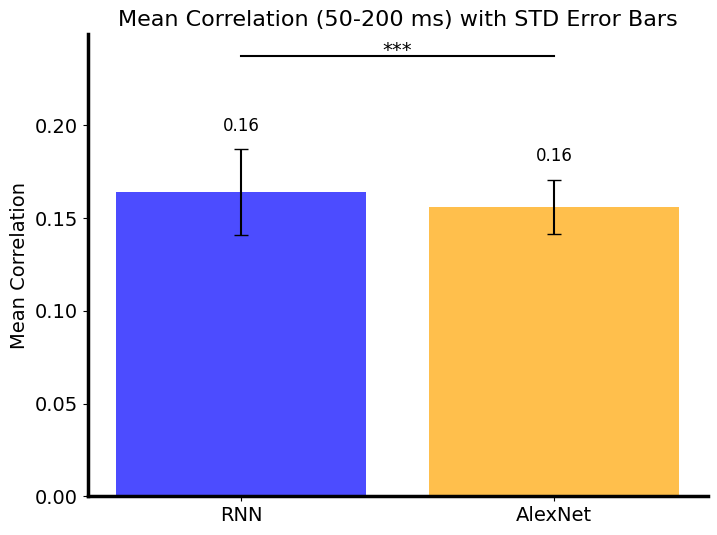

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Assuming r_rnn_PFC, r_alexnet_PFC, and time are defined
time = np.linspace(-200, 700, 171)
region = 'ITC'

# Convert 2D arrays to 1D
r_rnn_ITC_firing = np.squeeze(r_rnn_ITC_firing)  # Shape: (171,)
r_alexnet_ITC_firing = np.squeeze(r_alexnet_ITC_firing)  # Shape: (171,)

# Apply Gaussian smoothing
sigma = 2  # Adjust as needed for the desired level of smoothing
r_rnn_smooth = gaussian_filter1d(r_rnn_ITC_firing, sigma=sigma)
r_alexnet_smooth = gaussian_filter1d(r_alexnet_ITC_firing, sigma=sigma)

# Plot original vs smoothed data
plt.figure(figsize=(10, 6))
plt.plot(time, r_rnn_smooth, linewidth=3, label='RNN', color='darkblue')
plt.plot(time, r_alexnet_smooth, linewidth=3, label='AlexNet', color='darkorange')

# Customize the plot
plt.grid(False)
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title(f'RDM Var Correlation RNN & CNN (Firing rate) in {region}', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Customize the legend
plt.legend(fontsize=16, loc='upper right', frameon=False)  # Top-right position without box


# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)


# Highlight the stimulus display from 0 to 50 ms with a gray region
plt.axvspan(0, 50, color='gray', alpha=0.4)

# Show the onset of stimulus with a dashed line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)

plt.tight_layout()  # Adjust layout to prevent overlap

# Highlight the stimulus display from 0 to 50 ms with a gray region
plt.axvspan(0, 50, color='gray', alpha=0.4)

# Show the onset of stimulus with a dashed line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)

plt.show()

# Step 1: Define the time window
time_window_start = 50  # Start of the window (ms)
time_window_end = 200   # End of the window (ms)

# Find indices corresponding to the time window
window_indices = np.where((time >= time_window_start) & (time <= time_window_end))[0]

if len(window_indices) == 0:
    raise ValueError('No time points found in the specified time window.')

# Extract the correlation coefficients within the time window
corr_rnn_window = r_rnn_ITC_firing[window_indices]
corr_alexnet_window = r_alexnet_ITC_firing[window_indices]

# Step 2: Calculate mean and standard deviation
mean_rnn = np.nanmean(corr_rnn_window)
std_rnn = np.nanstd(corr_rnn_window)
mean_alexnet = np.nanmean(corr_alexnet_window)
std_alexnet = np.nanstd(corr_alexnet_window)

# Step 3: Perform paired t-test
t_stat, p_value = ttest_rel(corr_rnn_window, corr_alexnet_window, nan_policy='omit')

# Step 4: Create bar plot with error bars
means = [mean_rnn, mean_alexnet]
stds = [std_rnn, std_alexnet]
labels = ['RNN', 'AlexNet']

ax2 = plt.figure(figsize=(8, 6))
bar_handle = plt.bar(range(len(means)), means, yerr=stds, capsize=5, color=['blue', 'orange'], alpha=0.7)
plt.xticks(range(len(means)), labels, fontsize=12)
plt.ylabel('Mean Correlation', fontsize=14)
plt.title('Mean Correlation (50-200 ms) with STD Error Bars', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Display exact values on top of the bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.01, f'{mean:.2f}', ha='center', fontsize=12)

# Annotate the plot with the p-value
annotation_x = [0, 1]
annotation_y = max(means) + max(stds) + 0.05
plt.plot(annotation_x, [annotation_y, annotation_y], 'k-', linewidth=1.5)

if p_value < 0.001:
    significance = '***'
elif p_value < 0.01:
    significance = '**'
elif p_value < 0.05:
    significance = '*'
else:
    significance = 'n.s.'

plt.text(0.5, annotation_y , significance, ha='center', fontsize=14)


# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)

# Optional: Add the exact p-value
# plt.text(0.5, annotation_y + 0.04, f'p = {p_value:.3f}', ha='center', fontsize=12)

plt.show()




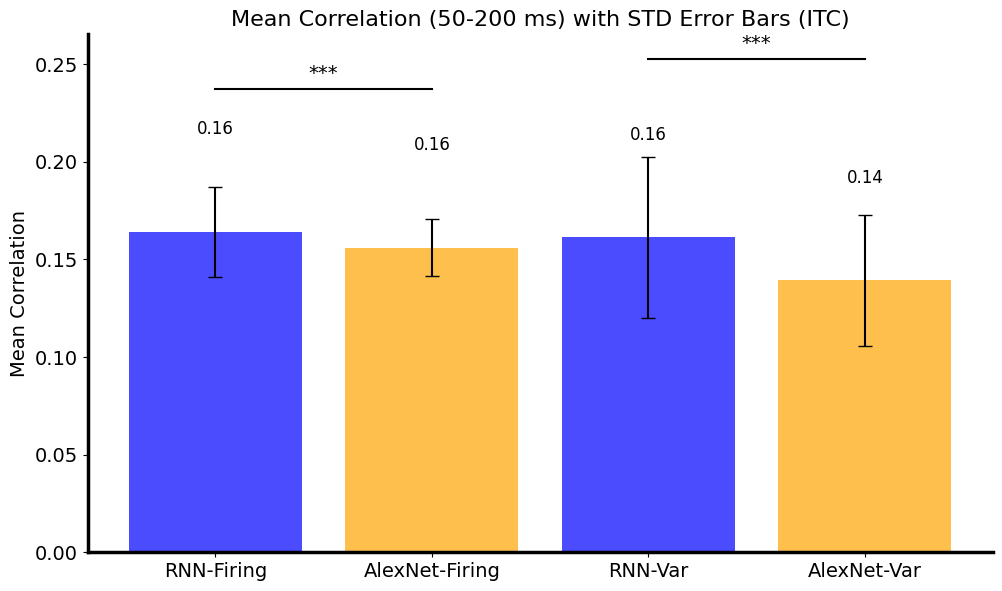

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Assuming time, r_rnn_PFC, r_alexnet_PFC, r_rnn_PFC_firing, r_alexnet_PFC_firing are defined

# Step 1: Define the time window
time_window_start = 50  # Start of the window (ms)
time_window_end = 200   # End of the window (ms)

# Find indices corresponding to the time window
window_indices = np.where((time >= time_window_start) & (time <= time_window_end))[0]

if len(window_indices) == 0:
    raise ValueError('No time points found in the specified time window.')

# Extract data for Firing rate
corr_rnn_firing = r_rnn_ITC_firing[window_indices]
corr_alexnet_firing = r_alexnet_ITC_firing[window_indices]

# Extract data for Variance
corr_rnn_var = r_rnn_ITC[window_indices]
corr_alexnet_var = r_alexnet_ITC[window_indices]

# Step 2: Calculate mean and standard deviation
mean_rnn_firing = np.nanmean(corr_rnn_firing)
std_rnn_firing = np.nanstd(corr_rnn_firing)
mean_alexnet_firing = np.nanmean(corr_alexnet_firing)
std_alexnet_firing = np.nanstd(corr_alexnet_firing)

mean_rnn_var = np.nanmean(corr_rnn_var)
std_rnn_var = np.nanstd(corr_rnn_var)
mean_alexnet_var = np.nanmean(corr_alexnet_var)
std_alexnet_var = np.nanstd(corr_alexnet_var)

# Step 3: Perform paired t-tests
t_stat_firing, p_value_firing = ttest_rel(corr_rnn_firing, corr_alexnet_firing, nan_policy='omit')
t_stat_var, p_value_var = ttest_rel(corr_rnn_var, corr_alexnet_var, nan_policy='omit')

# Step 4: Combine data for plotting
means = [mean_rnn_firing, mean_alexnet_firing, mean_rnn_var, mean_alexnet_var]
stds = [std_rnn_firing, std_alexnet_firing, std_rnn_var, std_alexnet_var]
x_labels = ['RNN-Firing', 'AlexNet-Firing', 'RNN-Var', 'AlexNet-Var']

# Step 5: Create a grouped bar plot
x = np.arange(len(x_labels))  # Bar positions
colors = ['blue', 'orange', 'blue', 'orange']  # Colors for bars

plt.figure(figsize=(10, 6))
bars = plt.bar(x, means, yerr=stds, capsize=5, color=colors, alpha=0.7)

# Add values above bars
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05,
             f'{means[i]:.2f}', ha='center', fontsize=12)

# Customize plot
plt.xticks(x, x_labels, fontsize=12)
plt.ylabel('Mean Correlation', fontsize=14)
plt.title('Mean Correlation (50-200 ms) with STD Error Bars (ITC)', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Annotate p-values
p_values = [p_value_firing, p_value_var]
annotations = [[0, 1], [2, 3]]  # Group bar pairs for significance annotations
for i, (p_value, annotation) in enumerate(zip(p_values, annotations)):
    significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'n.s.'
    annotation_y = max(means[annotation[0]:annotation[1]+2]) + max(stds[annotation[0]:annotation[1]+1]) + 0.05
    plt.plot(annotation, [annotation_y, annotation_y], 'k-', linewidth=1.5)
    plt.text(sum(annotation) / 2, annotation_y + 0.005, significance, ha='center', fontsize=14)

plt.tight_layout()



# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.show()


# Plot Kendall Correlation with Class Matrix ITC

In [34]:
r_VAR_ITC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_var_ITC.mat' , 'r_VAR')
r_Fr_ITC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_Fr_ITC.mat' , 'r_fR')

pVal_var_ITC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_Var_ITC.mat' , 'p_Var')
pVal_Fr_ITC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_Fr_ITC.mat' , 'p_Fr')

The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)


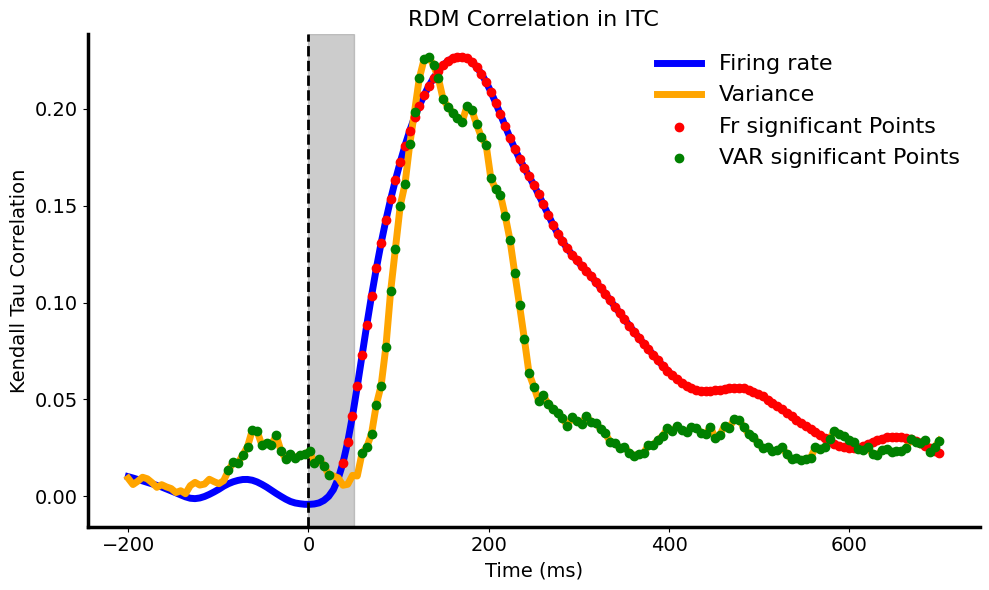

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming time, r_Fr_ITC, r_VAR_ITC, pVal_Fr_ITC, pVal_var_ITC, and region are already defined

plt.figure(figsize=(10, 6))

# Plot firing rate
plt.plot(time, r_Fr_ITC, linewidth=5, label='Firing rate', color='blue')

# Plot variance
plt.plot(time, r_VAR_ITC, linewidth=5, label='Variance', color='orange')

# Highlight significant points for firing rate
sig_Fr = (pVal_Fr_ITC < 0.05).flatten()  # Boolean array for significant points
plt.scatter(time[sig_Fr], r_Fr_ITC[sig_Fr], color='red', label='Fr significant Points', zorder=5)

# Highlight significant points for variance
sig_Var = (pVal_var_ITC < 0.05).flatten()  # Boolean array for significant points
plt.scatter(time[sig_Var], r_VAR_ITC[sig_Var], color='green', label='VAR significant Points', zorder=5)

# Customize the plot
plt.grid(False)

# Customize the legend
plt.legend(fontsize=16, loc='upper right', frameon=False)  # Top-right position without box

# Customize axis labels and title
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Kendall Tau Correlation', fontsize=14)
plt.title(f'RDM Correlation in {region}', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Highlight the stimulus display from 0 to 50 ms with a gray region
plt.axvspan(0, 50, color='gray', alpha=0.4)

# Show the onset of stimulus with a dashed line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Plot Kendall Correlation with Class Matrix PFC

In [38]:
r_VAR_PFC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_var_PFC.mat' , 'r_VAR')
r_Fr_PFC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/r_Fr_PFC.mat' , 'r_fR')

pVal_var_PFC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_Var_PFC.mat' , 'p_Var')
pVal_Fr_PFC = load_files('/content/drive/MyDrive/RNN_Alexnet_com/p_Fr_PFC.mat' , 'p_Fr')

The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)
The shape is: (171, 1)


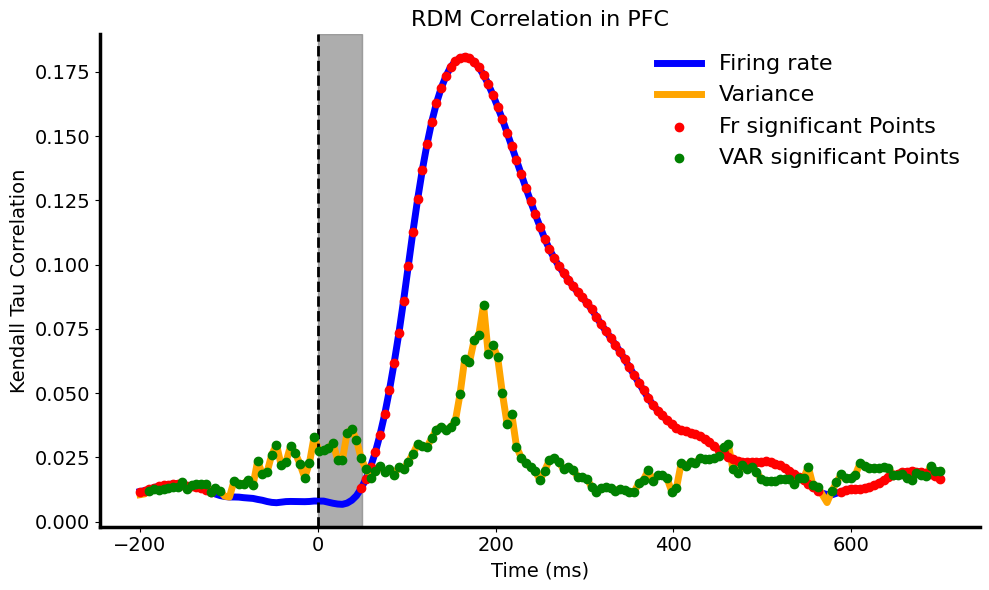

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming time, r_fR, r_VAR, p_Fr, p_Var, and region are already defined
region = 'PFC'
plt.figure(figsize=(10, 6))

# Plot firing rate
plt.plot(time, r_Fr_PFC, linewidth=5, label='Firing rate', color='blue')

# Plot variance
plt.plot(time, r_VAR_PFC, linewidth=5, label='Variance', color='orange')

# Highlight significant points for firing rate
sig_Fr = (pVal_Fr_PFC < 0.05).flatten()  # Boolean array for significant points
plt.scatter(time[sig_Fr], r_Fr_PFC[sig_Fr], color='red', label='Fr significant Points', zorder=5)

# Highlight significant points for variance
sig_Var = (pVal_var_PFC < 0.05).flatten()  # Boolean array for significant points
plt.scatter(time[sig_Var], r_VAR_PFC[sig_Var], color='green', label='VAR significant Points', zorder=5)

# Customize the plot
plt.grid(False)
plt.legend(fontsize=12)
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Kendall Tau Correlation', fontsize=14)
plt.title(f'RDM Correlation in {region}', fontsize=16)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# Highlight the stimulus display from 0 to 50 ms with a gray region
plt.axvspan(0, 50, color='gray', alpha=0.4)

# Customize the plot
plt.grid(False)

# Customize the legend
plt.legend(fontsize=16, loc='upper right', frameon=False)  # Top-right position without box

# Customize axis labels and title
plt.xlabel('Time (ms)', fontsize=14)
plt.ylabel('Kendall Tau Correlation', fontsize=14)
plt.title(f'RDM Correlation in {region}', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Fatten the borders
plt.gca().spines['left'].set_linewidth(2.5)
plt.gca().spines['bottom'].set_linewidth(2.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Highlight the stimulus display from 0 to 50 ms with a gray region
plt.axvspan(0, 50, color='gray', alpha=0.4)

# Show the onset of stimulus with a dashed line at time 0
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()




# CLass Mat

In [43]:
ClassMat = load_files('/content/drive/MyDrive/RNN_Alexnet_com/ClassMat.mat' , 'ClassMat')

The shape is: (144, 144)


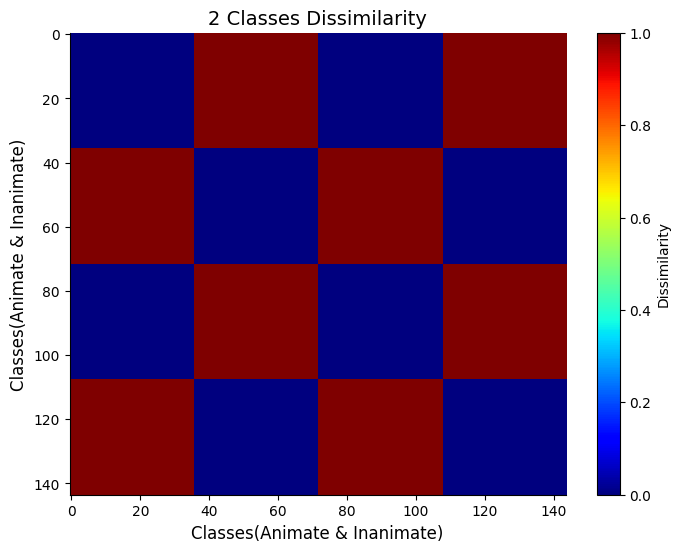

In [44]:
import numpy as np
import matplotlib.pyplot as plt


# Plot the matrix
plt.figure(figsize=(8, 6))
plt.imshow(ClassMat, cmap='jet', aspect='auto')  # Use 'bwr' colormap
plt.colorbar(label='Dissimilarity')  # Add a colorbar
plt.title('2 Classes Dissimilarity', fontsize=14)
plt.xlabel('Classes(Animate & Inanimate)', fontsize=12)
plt.ylabel('Classes(Animate & Inanimate)', fontsize=12)

# Customize axes (optional)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()
